# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import shap

In [2]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [3]:
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,Internet,RoundTrip,27,6,9,Sat,PERPNH,Australia,1,0,1,5.62,0
49996,1,Internet,RoundTrip,111,6,4,Sun,PERPNH,Australia,0,0,0,5.62,0
49997,1,Internet,RoundTrip,24,6,22,Sat,PERPNH,Australia,0,0,1,5.62,0
49998,1,Internet,RoundTrip,15,6,11,Mon,PERPNH,Australia,1,0,1,5.62,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [5]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [6]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [7]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [8]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [9]:
print("\nMissing Values:")


Missing Values:


In [10]:
print(df.isnull().sum())

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64


No missing value 

In [11]:
# Data Exploration
print("Dataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nClass Distribution:")
print(df['booking_complete'].value_counts(normalize=True))

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  int64  
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memor

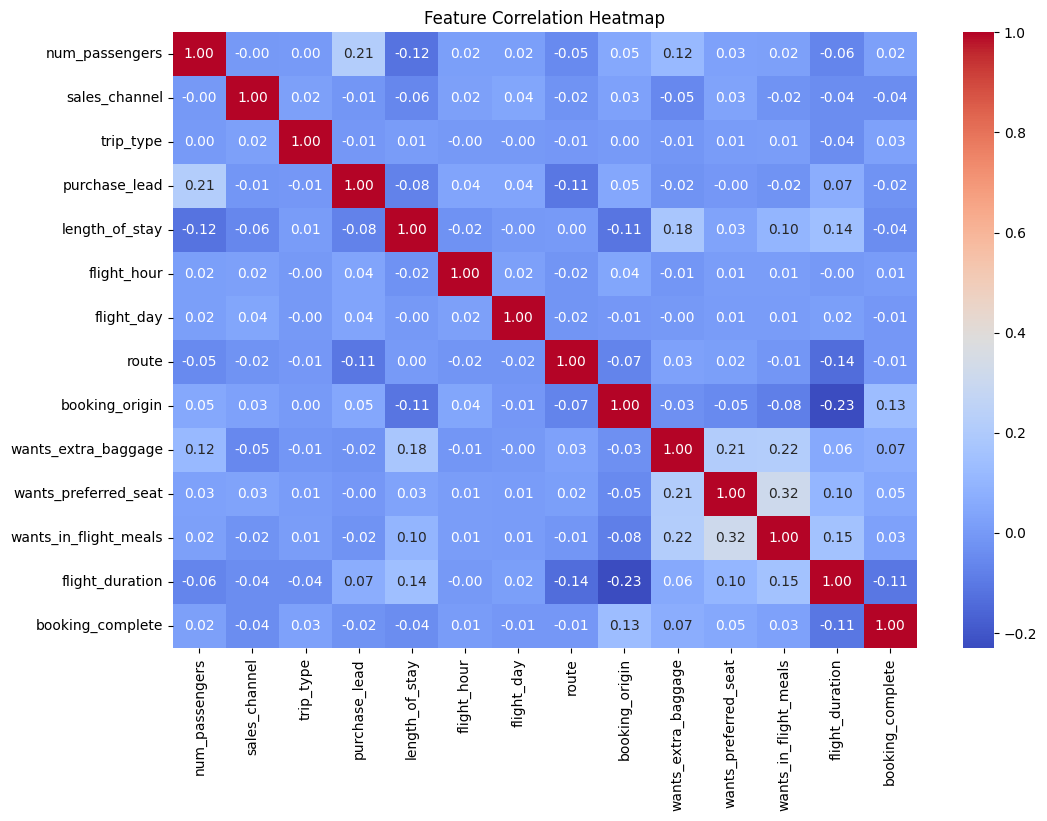

In [12]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical columns
df_encoded = df.copy()
for col in df.select_dtypes(include=['object']).columns:  # Select categorical columns
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

# Correlation Heatmap with Encoded Data
plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

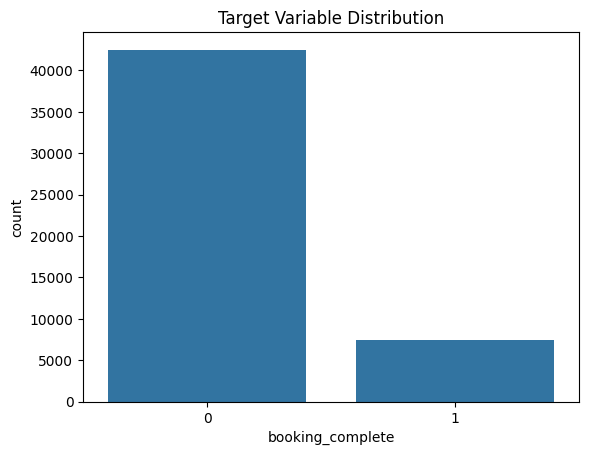

In [13]:
# Visualizing Class Distribution
sns.countplot(x='booking_complete', data=df)
plt.title('Target Variable Distribution')
plt.show()

In [14]:
# Convert Categorical Features to Numeric
categorical_features = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']
le = LabelEncoder()
for col in categorical_features:
    df[col] = le.fit_transform(df[col])

In [15]:
# Feature Engineering
df['weekend_flight'] = df['flight_day'].apply(lambda x: 1 if x in ['Sat', 'Sun'] else 0)
df['long_stay'] = df['length_of_stay'].apply(lambda x: 1 if x > 14 else 0)

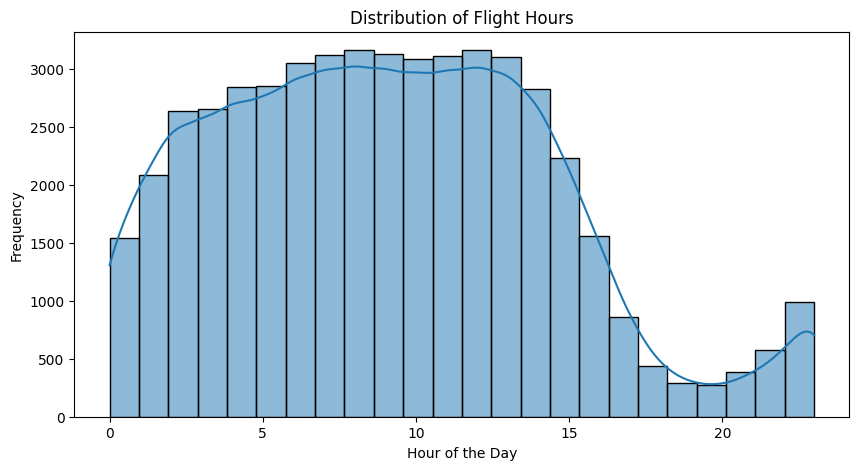

In [16]:
# Distribution of Flight Hours
plt.figure(figsize=(10,5))
sns.histplot(df['flight_hour'], bins=24, kde=True)
plt.title('Distribution of Flight Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.show()

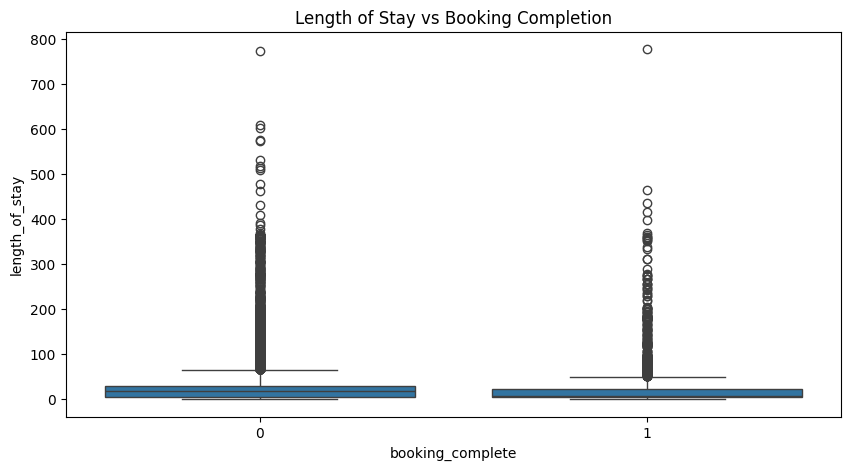

In [17]:
# Boxplot for Length of Stay
plt.figure(figsize=(10,5))
sns.boxplot(x='booking_complete', y='length_of_stay', data=df)
plt.title('Length of Stay vs Booking Completion')
plt.show()

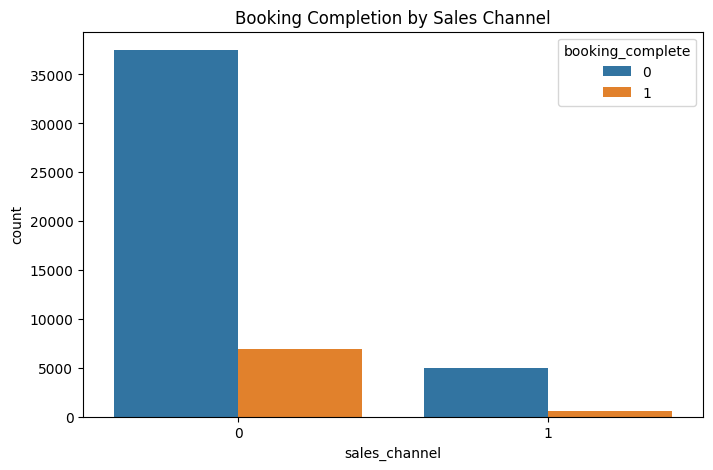

In [18]:
# Countplot for Sales Channel
plt.figure(figsize=(8,5))
sns.countplot(x='sales_channel', hue='booking_complete', data=df)
plt.title('Booking Completion by Sales Channel')
plt.show()

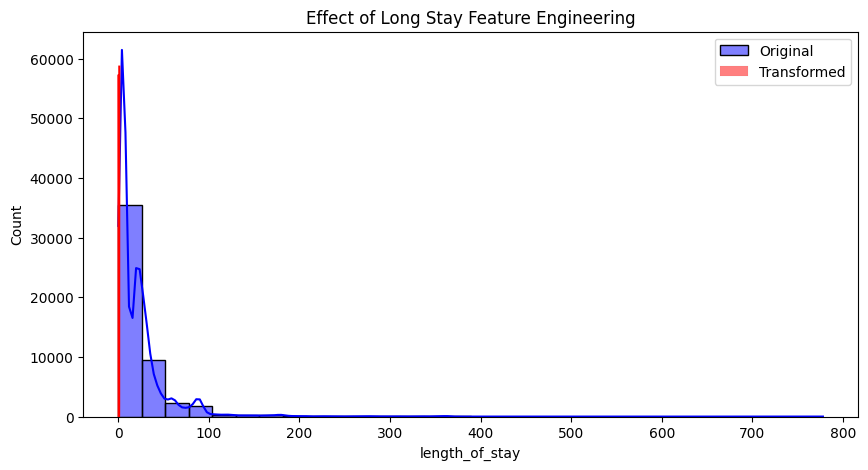

In [19]:
# Histogram of Length of Stay before and after transformation
plt.figure(figsize=(10,5))
sns.histplot(df['length_of_stay'], bins=30, kde=True, color='blue', label='Original')
sns.histplot(df['long_stay'], bins=3, kde=True, color='red', label='Transformed')
plt.legend()
plt.title('Effect of Long Stay Feature Engineering')
plt.show()

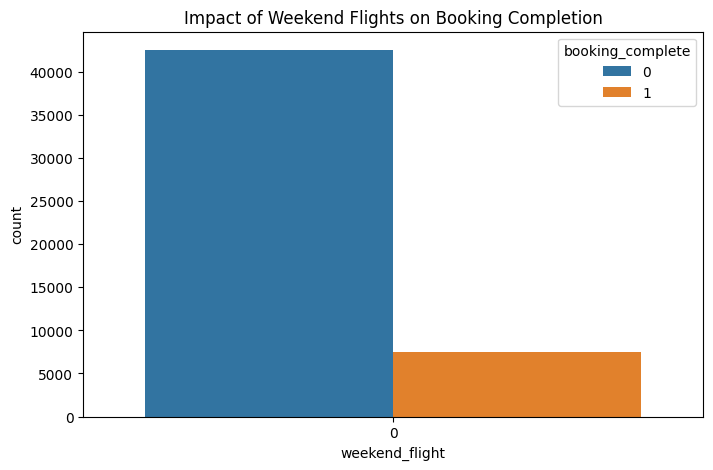

In [20]:
# Countplot for Weekend Flights
plt.figure(figsize=(8,5))
sns.countplot(x='weekend_flight', hue='booking_complete', data=df)
plt.title('Impact of Weekend Flights on Booking Completion')
plt.show()

BUILDING MODEL FOR PREDICTION OF TARGET OUTCOME

In [21]:
# Splitting Data
X = df.drop(columns=['booking_complete'])
y = df['booking_complete']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
# Scaling Numeric Features
scaler = StandardScaler()
numeric_features = ['purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

In [23]:
# Train Random Forest Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [24]:
# Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8542

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      8520
           1       0.54      0.09      0.16      1480

    accuracy                           0.85     10000
   macro avg       0.70      0.54      0.54     10000
weighted avg       0.82      0.85      0.81     10000



In [25]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Initialize Stratified KFold (preserves class distribution in each fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store scores from cross-validation
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []


# Cross-validation loop
for train_idx, val_idx in cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Fit the model
    rf.fit(X_train_fold, y_train_fold)
    
    # Predict on validation fold
    y_pred_fold = rf.predict(X_val_fold)
    
    # Calculate metrics for this fold
    accuracy_scores.append(accuracy_score(y_val_fold, y_pred_fold))
    precision_scores.append(precision_score(y_val_fold, y_pred_fold))
    recall_scores.append(recall_score(y_val_fold, y_pred_fold))
    f1_scores.append(f1_score(y_val_fold, y_pred_fold))

# Average scores from cross-validation
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

# Output cross-validation results
print(f"Cross-Validation Results (Average scores over {cv.get_n_splits()} folds):")
print(f"Accuracy: {avg_accuracy:.4f}")
print(f"Precision: {avg_precision:.4f}")
print(f"Recall: {avg_recall:.4f}")
print(f"F1-Score: {avg_f1:.4f}")

# Train final model on the whole training set
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

Cross-Validation Results (Average scores over 5 folds):
Accuracy: 0.8506
Precision: 0.5129
Recall: 0.0899
F1-Score: 0.1528


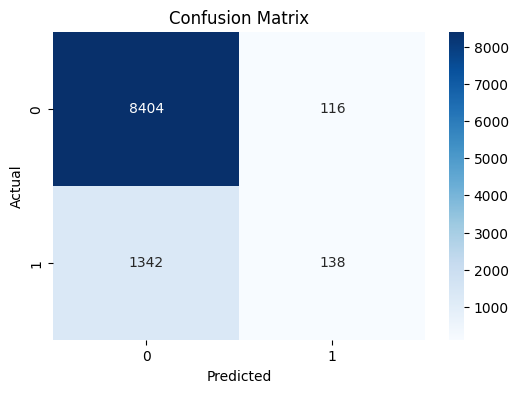

In [26]:
# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [27]:
# Classification Report
print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_pred))


Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      8520
           1       0.54      0.09      0.16      1480

    accuracy                           0.85     10000
   macro avg       0.70      0.54      0.54     10000
weighted avg       0.82      0.85      0.81     10000



In [28]:
#Save the Model Using pickle

import pickle

# Save the trained model
with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(rf, f)

print("Model saved successfully!")

Model saved successfully!


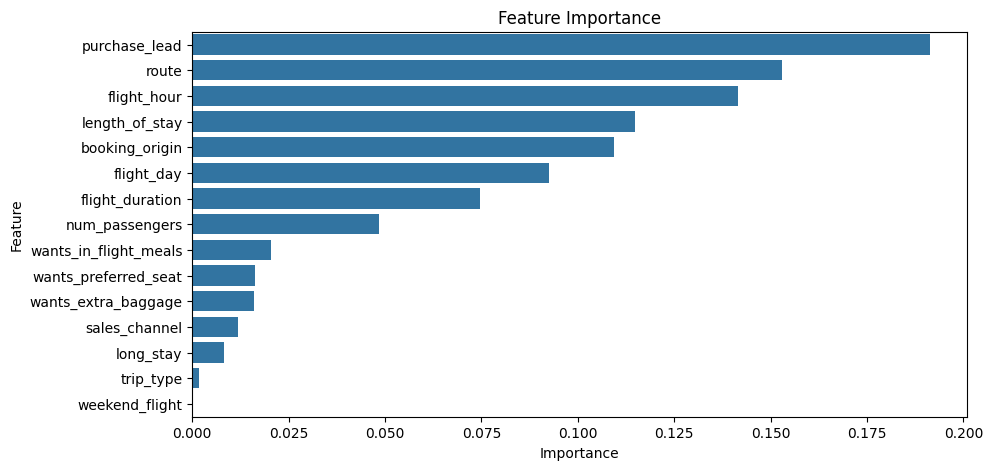

In [29]:
# Feature Importance
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance')
plt.show()

In [30]:
# Save Results
feature_importances.to_csv("feature_importance.csv", index=False)

print("Model training and evaluation completed successfully!")

Model training and evaluation completed successfully!


In [31]:
# Load the trained model for Inference
with open("random_forest_model.pkl", "rb") as f:
    loaded_rf = pickle.load(f)

# Make predictions
y_pred = loaded_rf.predict(X_test)
